In [1]:
import pandas as pd
import numpy as np
import os
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

cartable = pd.read_pickle(os.path.join('../datasets', 'car_original_dataset.pkl'))
cartable.columns = [str.lower(col.replace('.', '_')) for col in cartable.columns]
cartable['origin'] = cartable['origin'].map({0: False, 1: True})
cartable['automatic_gearbox'] = cartable['automatic_gearbox'].map({0: False, 1: True})

preprocessed_data = pd.read_pickle('..//datasets//1993CarsPrep.pkl')

query_workload = ["type == 'Sporty' and origin == 0", "type != 'Sporty' and origin == 1", "make == 'Ford' or make == 'Chevrolet'"]

In [2]:
x_size = 10
y_size = 10
learning_rate = 0.5
sigma = math.ceil(x_size*0.5)
training_iterations = 5000
excluded_size = 1
query_id = 1

In [3]:
concept = cartable.query(query_workload[query_id]).index.to_list()

In [4]:
excluded = random.choice(concept)

In [5]:
used_ids = [i for i in cartable.index.to_list() if i != excluded]

In [6]:
concept = [i for i in concept if i != excluded]

In [7]:
#example = preprocessed_data.loc[[excluded] + random.choices(concept, k=3)].values
example = preprocessed_data.loc[excluded].values

In [8]:
data = preprocessed_data.loc[used_ids].values

In [9]:
def get_label(idx, concept):
    if idx in concept:
        return 'Positive'
    else:
        return 'Unlabeled'

labels = [get_label(x, concept) for x in cartable.index.to_list() if x != excluded]

from minisom import MiniSom
som = MiniSom(10, y_size, len(data[0]), sigma=sigma, learning_rate=learning_rate, 
            neighborhood_function='gaussian')

som.pca_weights_init(data)
som.train_random(data, training_iterations, verbose=False)

In [10]:
labels_map = som.labels_map(data, labels)
label_names = labels

def get_classification(item, labels_map, som):
    winner = som.winner(item)
    predicted_labels = list(labels_map[winner].keys())

    if 'Positive' in predicted_labels:
        return 'Positive'
    else:
        return 'Negative'

def get_expected_label(idx, concept):
    if idx in concept:
        return 'Positive'
    else:
        return 'Negative'

expected = [get_expected_label(x, concept) for x, e in enumerate(data, start=1)]
predicted = [get_classification(x, labels_map, som) for x in data.tolist()]

In [11]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

    Negative       0.98      0.75      0.85        55
    Positive       0.72      0.97      0.83        37

   micro avg       0.84      0.84      0.84        92
   macro avg       0.85      0.86      0.84        92
weighted avg       0.87      0.84      0.84        92



In [12]:
def visualize_som(labels):
    labels_map = som.labels_map(data, labels)
    label_names = np.unique(labels)

    plt.figure(figsize=(x_size, y_size))
    ax = plt.gca()
    ax.set_facecolor('xkcd:white')
    the_grid = GridSpec(x_size, y_size)
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in label_names]
        plt.subplot(the_grid[x_size-1-position[1], position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)
    plt.legend(patches, label_names, bbox_to_anchor=(0, 1.5), ncol=3)
    plt.show()


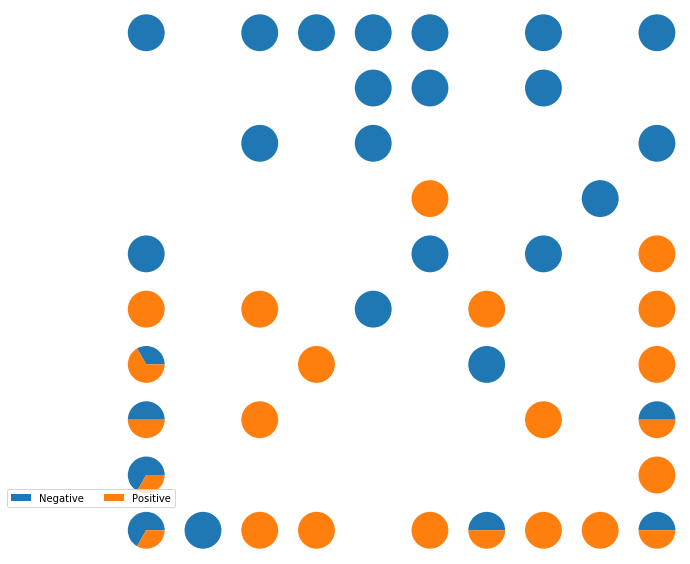

In [13]:
visualize_som(expected)

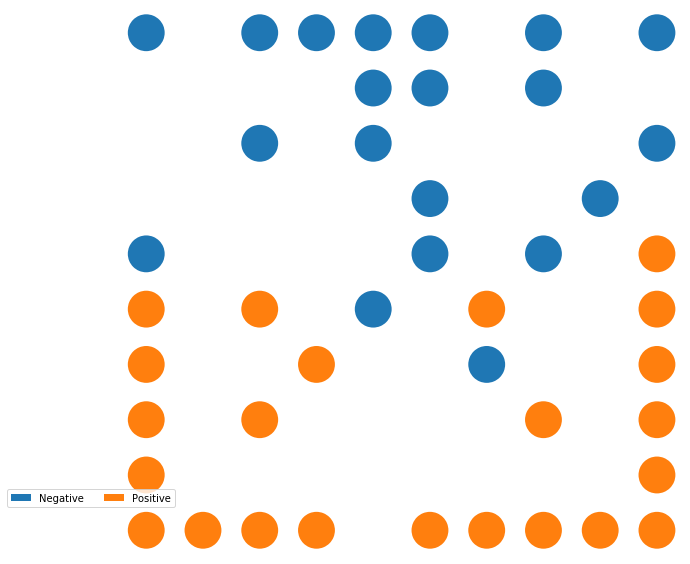

In [14]:
visualize_som(predicted)

In [15]:
exwin = som.winner(excluded)

accuracy = sum([1 for c in concept if som.winner(c) == exwin])/len(concept)
print(accuracy)

0.868421052631579
